<center>
<a href="http://uf-mi.u-bordeaux.fr/MSS/" ><img src="https://www.math.u-bordeaux.fr/~jbigot/Site/Enseignement_files/logo_MAS_MSS.jpg" style="float:left; max-width: 400px; display: inline" alt="INSA"/></a>

<a href="https://www.math.u-bordeaux.fr/" ><img src="https://www.math.u-bordeaux.fr/~jbigot/Site/Enseignement_files/LogoIMB.jpg" style="float:right; max-width: 250px; display: inline" alt="IMT"/> </a>
</center>

# <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 200px; display: inline" alt="Python"/></a> UE M2 Master MAS-MSS et CIMI ISI Projet Données Massives

In [34]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

C:\Users\ainau\AppData\Local\Temp\ipykernel_13676\3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


# Text sentiment avec Pytorch
<a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 150px; display: inline" alt="Python"/></a> & <a href="http://scikit-learn.org/stable/#"><img src="http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png" style="max-width: 180px; display: inline" alt="Scikit-Learn"/></a>


**Résumé**: Ce calepin propose l'utilisation des librairies de `Pytorch` pour l'implémentation de 4 modèles de réseaux de neurones de NLP associés a text sentiment. Les methodes à tester sont: BOW (Bag of words), RNN, GRU et LSTM.

On vous donne un simple BOW algorithme pour ensuite devoir implémenter les 3 dernier algorithmes (listés avant) à l'aide de `Pytorch` en grande dimension sur un problème de classification appelé Text Sentiment. En particulier, on va utiliser la base de données AG_NEWS qui associe à une nouvelle en texte, une classe parmi:

   {1 : Monde,
   2 : Sports,
   3 : Affaires,
   4 : Science/Technologie}

## 0. Prise en main des données

On télécharge les données et on las explore

In [35]:
# !pip uninstall torch torchtext -y
# !pip install torch==2.1.2 torchtext==0.16.2
# !pip install 'portalocker>=2.0.0'
# !pip install torchdata
# # Relancez le runtime editor
# # puis commentez une fois les bibliotheques ont été installées.

In [36]:
import torch
from torchtext.datasets import AG_NEWS

In [37]:
train_iter = iter(AG_NEWS(split='train'))         #Iterateur de données

In [38]:
# Visulisation des données
j=1
for i in range(1000):
    w=next(train_iter)
    if w[0]==j:                    # On affiche une donnée par classe
        print(w)
        j=j+1

(1, 'Venezuelans Vote Early in Referendum on Chavez Rule (Reuters) Reuters - Venezuelans turned out early\\and in large numbers on Sunday to vote in a historic referendum\\that will either remove left-wing President Hugo Chavez from\\office or give him a new mandate to govern for the next two\\years.')
(2, "Kobe Bryant Due Back in Court Monday (AP) AP - With Kobe Bryant's sexual assault trial scheduled to begin in less than two weeks, speculation is mounting that prosecutors are looking for a way to dismiss the charge after a series of setbacks.")
(3, 'Funds: Are Bond Funds Hazardous?  (Clint Willis is a freelance writer who covers mutual funds  for Reuters. Any opinions in the column are solely those of Mr.  Willis.)')
(4, "Cold Winters Slow Northeast Hemlock Pest (AP) AP - New England's bitterly cold winters may be hard on people, but they have been even harder on an Asian insect that's threatening to destroy hemlocks, one of the signature trees of the region's forests.")


In [39]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokeniser = get_tokenizer('basic_english')
train_iter = AG_NEWS(split='train')
test_iter = AG_NEWS(split='test')

def tokens_dans_nouvelle(data_iter):
    for _, text in data_iter:
        yield tokeniser(text)

vocab = build_vocab_from_iterator(tokens_dans_nouvelle(train_iter), specials=["<unk>"])    #construit un vocabulaire et associe a chaque mot un numero
vocab.set_default_index(vocab["<unk>"])
print("Taille du vocabulaire : \n",len(vocab))

Taille du vocabulaire : 
 95811


In [40]:
print(list(vocab.get_stoi().items())[:10])  # Affiche les 10 premiers mots du vocabulaire

[('television', 736), ('misnomer', 38248), ('television-watching', 90181), ('new', 23), ('costs', 531), ('7-week', 13425), ('dutch', 1256), ('35-10', 34767), ('tarceva', 19362), ('confidence', 1239)]


In [41]:
#Pipelines
text_pipeline = lambda x: vocab(tokeniser(x))
label_pipeline = lambda x: int(x) - 1  # On decale les labels, maintenant il sont numerotés 0,1,2,3

In [42]:
# Manipulation des données avec le vocabulaire
train_iter=iter(AG_NEWS(split='train'))
label, nouvelle = next(train_iter)
label_1, nouvelle_1 = next(train_iter)
tokens_nouvelle=tokeniser(nouvelle)
print('Tokens pour la nouvelle : \n',tokeniser(nouvelle),'\n')
print('Indices des tokens dans le vocab : \n',text_pipeline(nouvelle),'\n')
print('Indices des labels : \n',label_pipeline(label),'\n')
print('Vrai label : \n',label)

Tokens pour la nouvelle : 
 ['wall', 'st', '.', 'bears', 'claw', 'back', 'into', 'the', 'black', '(', 'reuters', ')', 'reuters', '-', 'short-sellers', ',', 'wall', 'street', "'", 's', 'dwindling\\band', 'of', 'ultra-cynics', ',', 'are', 'seeing', 'green', 'again', '.'] 

Indices des tokens dans le vocab : 
 [431, 425, 1, 1605, 14838, 113, 66, 2, 848, 13, 27, 14, 27, 15, 50725, 3, 431, 374, 16, 9, 67507, 6, 52258, 3, 42, 4009, 783, 325, 1] 

Indices des labels : 
 2 

Vrai label : 
 3


In [43]:
# Comparateur de longeur des tokens dans les nouvelles
print("Nombre de tokens dans nouvelle : \n" , len(tokeniser(nouvelle)), '\n')
print("Nombre de tokens dans nouvelle_1: \n" , len(tokeniser(nouvelle_1)), '\n')

Nombre de tokens dans nouvelle : 
 29 

Nombre de tokens dans nouvelle_1: 
 42 



Comme les données viennent donnés par des extraits des nouvelles, les longueurs peuvent varier.
Ça génère un problème que l'on va resoudre, mais comment ?

L'operation plus courant es de alonger les textes pour avoir une longueur commune, pour raisons de securité on établi une taille maximal $L$ et si jamais une nouvelle depasse cette taille, on va la tronquer (jeter la suite de la nouvelle); tandis que les nouvelles qui ne depassent pas la longueur maximal sont remplies de zeros jusqu'à obtenir la longueur maximal.

Le `padding` forme partie de la librarie `Pytorch`, ici on explore cette fonction.

In [44]:
# Padding
from torch.nn.utils.rnn import pad_sequence

WE_nouvelle = torch.tensor(text_pipeline(nouvelle), dtype=torch.int64)
WE_nouvelle_1 = torch.tensor(text_pipeline(nouvelle_1), dtype=torch.int64)

padded = pad_sequence([WE_nouvelle,WE_nouvelle_1])
print("Padded première suite: {}".format(padded[:,0]))
print("Longueur première suite: {}".format(len(padded[:,0])))
print("Padded deuxième suite: {}".format(padded[:,1]))
print("Longueur deuxième suite: {}".format(len(padded[:,1])))

Padded première suite: tensor([  431,   425,     1,  1605, 14838,   113,    66,     2,   848,    13,
           27,    14,    27,    15, 50725,     3,   431,   374,    16,     9,
        67507,     6, 52258,     3,    42,  4009,   783,   325,     1,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])
Longueur première suite: 42
Padded deuxième suite: tensor([15874,  1072,   854,  1310,  4250,    13,    27,    14,    27,    15,
          929,   797,   320, 15874,    98,     3, 27657,    28,     5,  4459,
           11,   564, 52790,     8, 80617,  2125,     7,     2,   525,   241,
            3,    28,  3890, 82814,  6574,    10,   206,   359,     6,     2,
          126,     1])
Longueur deuxième suite: 42


Toute au début ces deux vecteurs étaint de differente longueur et maintenant ils ont tous les deux la même taille, la plus petite des nouvelles a des zeros à la fin.

On aimerait bien que le `DataLoader` fasse cette operations dans le processus de batching.
Heureusement `DataLoader` nous permet de modifier le comportement d'un batch avec l'argument `collate_fn`.

In [45]:
# Fonction collator pour integrer le padding dans le DataLoader
from torch.utils.data import DataLoader
import numpy as np

def collator(batch):
    liste_label, liste_texte = [], []
    for (_label, _texte) in batch:
         liste_label.append(label_pipeline(_label))
         texte_processe = torch.tensor(text_pipeline(_texte), dtype=torch.int64)
         liste_texte.append(texte_processe)
    labels = torch.tensor(liste_label, dtype=torch.int64)
    data = pad_sequence(liste_texte)
    return [data, labels]

train_iter = AG_NEWS(split='train')
dataloader = DataLoader(train_iter, batch_size=100, shuffle=True, collate_fn=collator)

Étant donné que l'ensemble d'entrainement est trop grande, on va la reduire

In [46]:
# DataLoader pour train et test + garder 10% des données.
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

BATCH_SIZE = 100

train_iter=AG_NEWS(split='train')
test_iter=AG_NEWS(split='test')

train_dataset = to_map_style_dataset(train_iter)                            #Soit les batchs sont un iterateur, soit ils sont des fonctions, ici on transforme avec la finalitée de reduire la taille de train.
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.1)                                   #Comme la base de données est grande, on va prendre un 10% aleatoire comme ensemble d'entrainement.
train_01, _ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_loader = DataLoader(train_01, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collator)
test_loader = DataLoader(test_iter, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collator)

## 1 Bag Of Words (BOW)

D'abord on va génèrer un reseau simple **BOW**, ici les parametres à apprendre du modèle contiennent le `codebook`.
On defini à continuation quelques parametres du reseau.

In [47]:
#Definition de paramètres à utiliser dans le modèle
TAILLE_VOCAB = len(vocab)
DIM_EMBED = 100
DIM_CACHEE = 64
NUM_OUTPUTS = 4
NUM_EPOCHS = 10

Comme vu dans la dernière classe, on va utiliser le `nn.Module` de `Pytorch`.
Pour rajouter les `codebook` dans l'ensemble des paramètres à apprendre on utilise la fonction `nn.Embedding`. Cette fonction **doit** être utilisé au debut du forward pass pour changer les entrées a Embeddings.

Une fois qu'on a appliquée la fonction `nn.Embedding` on aura un minibatch de taille $L \times$ `BATCH_SIZE` $\times$ `EMBED_DIM`.
Pour l'algorithme **BOW** une fois donnée une nouvelle on va considerer la moyenne des embeddings dans la nouvelle et puis on va faire la classification.

In [48]:
# Definition du modèle
import torch.nn as nn
import torch.nn.functional as F

class BOW(nn.Module):
    def __init__(self, taille_vocab, taille_embed, dim_cachee, num_outputs):
        super().__init__()
        self.embedding = nn.Embedding(taille_vocab, taille_embed)
        self.fc1 = nn.Linear(taille_embed, dim_cachee)
        self.fc2 = nn.Linear(dim_cachee, num_outputs)

    def forward(self, x):
        embed = self.embedding(x)
        embed_mean = torch.mean(embed, dim=0)
        h = self.fc1(embed_mean)
        h = F.relu(h)
        h = self.fc2(h)
        return h

Le model defini maintenant peut etre entrainé et evalué.

La façon dont les programmes sont écris (`nn.Module` et `DataLoader`) permet d'utiliser la plus part pour faire aussi **RRN, GRU** et **LSTM**.

<font size="4">
Note: Dependant de votre ordinateur, l'entrainement peut prendrè quelques heures, ceci depend de le nombre d `épochs` et de quelle proportion des données d'entrainement vous voulez considerer.

Pour commencer considerez epoch = 1 ou 2, bien-sûr ça va impacter l`accuracy`, mais lorsque votre programme tourne et vous avez fini, mettez plus d `èpochs`pour amerliorer votre reseau.
</font>

In [49]:
import time # Pour regarder le temps d'execution des routines

## Entrainement
# Initialisation
model = BOW(taille_vocab = TAILLE_VOCAB,
    taille_embed = DIM_EMBED,
    dim_cachee = DIM_CACHEE,
    num_outputs = NUM_OUTPUTS,
)

# Cross-entropy Loss et optimisateur Adam
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Itere l'entrainement au long des minibatchs

temps_final = 0

print("Début de l'entraînement...\n")
for epoch in range(1, NUM_EPOCHS+1):
    correct = 0
    num_exemples = 0
    temps_demarrage = time.time()
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        y = model(inputs)
        loss = criterion(y, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
        num_exemples += len(labels)

        temps_epoch = time.time()-temps_demarrage

    # Print training progress
    if epoch % 1 == 0:
        acc = correct/num_exemples
        print("Epoch: {0} \t Train Loss: {1:.4f} \t Train Acc: {2:.4f} \t Temps Epoch: {3:.4f}".format(epoch, loss, acc, temps_epoch))

    temps_final +=temps_epoch

print("\nTemps d'entrainement: {:.4f}".format(temps_final),'\n')

## Testing
print("Évaluation en cours...\n")
correct = 0
num_exemples = 0

with torch.no_grad():
    # Iterate through test set minibatchs
    for inputs, labels in test_loader:
        # Forward pass
        y = model(inputs)

        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
        num_exemples += len(labels)

print('Test accuracy: {:.4f}'.format(correct/num_exemples),'\n')

Début de l'entraînement...

Epoch: 1 	 Train Loss: 1.3506 	 Train Acc: 0.3158 	 Temps Epoch: 10.8230
Epoch: 2 	 Train Loss: 1.0438 	 Train Acc: 0.5311 	 Temps Epoch: 10.5040
Epoch: 3 	 Train Loss: 0.7320 	 Train Acc: 0.7249 	 Temps Epoch: 10.7610
Epoch: 4 	 Train Loss: 0.4248 	 Train Acc: 0.8193 	 Temps Epoch: 10.7848
Epoch: 5 	 Train Loss: 0.3948 	 Train Acc: 0.8671 	 Temps Epoch: 11.1901
Epoch: 6 	 Train Loss: 0.3240 	 Train Acc: 0.8895 	 Temps Epoch: 10.6940
Epoch: 7 	 Train Loss: 0.3384 	 Train Acc: 0.9112 	 Temps Epoch: 10.4760
Epoch: 8 	 Train Loss: 0.2891 	 Train Acc: 0.9252 	 Temps Epoch: 10.5290
Epoch: 9 	 Train Loss: 0.3096 	 Train Acc: 0.9398 	 Temps Epoch: 10.6156
Epoch: 10 	 Train Loss: 0.1407 	 Train Acc: 0.9482 	 Temps Epoch: 10.5800

Temps d'entrainement: 106.9575 

Évaluation en cours...

Test accuracy: 0.8684 



## 2 RNNs

**BOW** prends la moyenne sur les embeddings des mots du message, ceci se traduit en un perte d'information (on garde un observable macro de l'échantillon).

Comment cette manipulation affecte le model de classification?

Modifiez le **BOW** pour utiliser an **RNN** à continuation.
Une fois le **RNN** a été construit avec success, faites la même chose pour **GRU** et **LSTM**


Pour implementer RNN, GRU et LSTM vous allez utiliser la commande suivante

```torch.mean(ht, dim=0)```

qui prend la moyenne des vecteurs cachés pour faire la classification. Ici ht est le tenseur associé a la premier sortie de RNN, GRU et LSTM.



In [50]:
class RNN(nn.Module):
    def __init__(self, taille_vocab, taille_embed, dim_cachee, num_outputs):
        super().__init__()
        self.embedding = nn.Embedding(taille_vocab, taille_embed)
        self.rnn = nn.RNN(input_size=taille_embed, hidden_size=dim_cachee) 
        self.fc = nn.Linear(dim_cachee, num_outputs)

    def forward(self, x):
        embed = self.embedding(x)
        output, _ = self.rnn(embed)
        h_mean = torch.mean(output, dim=0)
        h = self.fc(h_mean)
        return h

In [51]:
## Entrainement
# Initilisation
model = RNN(taille_vocab = TAILLE_VOCAB,
    taille_embed = DIM_EMBED,
    dim_cachee = DIM_CACHEE,
    num_outputs = NUM_OUTPUTS,
)

# Cross-entropy Loss et optimisateur Adam
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Itere l'entrainement au long des minibatchs

temps_final = 0

print("Début de l'entraînement...\n")
for epoch in range(1, NUM_EPOCHS+1):
    correct = 0
    num_exemples = 0
    temps_demarrage = time.time()
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        y = model(inputs)
        loss = criterion(y, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
        num_exemples += len(labels)

        temps_epoch = time.time()-temps_demarrage

    # Print training progress
    if epoch % 1 == 0:
        acc = correct/num_exemples
        print("Epoch: {0} \t Train Loss: {1:.4f} \t Train Acc: {2:.4f} \t Temps Epoch: {3:.4f}".format(epoch, loss, acc, temps_epoch))

    temps_final +=temps_epoch

print("\nTemps d'entrainement: {:.4f}".format(temps_final),'\n')

## Testing
print("Évaluation en cours...\n")
correct = 0
num_exemples = 0

with torch.no_grad():
    # Iterate through test set minibatchs
    for inputs, labels in test_loader:
        # Forward pass
        y = model(inputs)

        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
        num_exemples += len(labels)

print('Test accuracy: {:.4f}'.format(correct/num_exemples),'\n')

Début de l'entraînement...

Epoch: 1 	 Train Loss: 1.1826 	 Train Acc: 0.3736 	 Temps Epoch: 15.0975
Epoch: 2 	 Train Loss: 0.8534 	 Train Acc: 0.5807 	 Temps Epoch: 14.6740
Epoch: 3 	 Train Loss: 0.5252 	 Train Acc: 0.7268 	 Temps Epoch: 14.5900
Epoch: 4 	 Train Loss: 0.6624 	 Train Acc: 0.8015 	 Temps Epoch: 14.4596
Epoch: 5 	 Train Loss: 0.4186 	 Train Acc: 0.8560 	 Temps Epoch: 14.6260
Epoch: 6 	 Train Loss: 0.5014 	 Train Acc: 0.8735 	 Temps Epoch: 14.8280
Epoch: 7 	 Train Loss: 0.3730 	 Train Acc: 0.9073 	 Temps Epoch: 14.7765
Epoch: 8 	 Train Loss: 0.2516 	 Train Acc: 0.9032 	 Temps Epoch: 14.7066
Epoch: 9 	 Train Loss: 0.2502 	 Train Acc: 0.9365 	 Temps Epoch: 14.2100
Epoch: 10 	 Train Loss: 0.2244 	 Train Acc: 0.9417 	 Temps Epoch: 14.3200

Temps d'entrainement: 146.2883 

Évaluation en cours...

Test accuracy: 0.8180 



## 3 GRU

In [52]:
class GRU(nn.Module):
    def __init__(self, taille_vocab, taille_embed, dim_cachee, num_outputs):
        super().__init__()
        self.embedding = nn.Embedding(taille_vocab, taille_embed)
        self.gru = nn.GRU(taille_embed, dim_cachee)
        self.fc = nn.Linear(dim_cachee, num_outputs)
    
    def forward(self, x):
        embed = self.embedding(x)
        output, _ = self.gru(embed)
        h_mean = torch.mean(output, dim=0)
        h = self.fc(h_mean)
        return h

In [53]:
## Entrainement
# Initialisation
model = GRU(taille_vocab = TAILLE_VOCAB,
    taille_embed = DIM_EMBED,
    dim_cachee = DIM_CACHEE,
    num_outputs = NUM_OUTPUTS,
)

# Cross-entropy Loss et optimisateur Adam
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Itere l'entrainement au long des minibatchs

temps_final = 0

print("Début de l'entraînement...\n")
for epoch in range(1, NUM_EPOCHS+1):
    correct = 0
    num_exemples = 0
    temps_demarrage = time.time()
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        y = model(inputs)
        loss = criterion(y, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
        num_exemples += len(labels)

        temps_epoch = time.time()-temps_demarrage

    # Print training progress
    if epoch % 1 == 0:
        acc = correct/num_exemples
        print("Epoch: {0} \t Train Loss: {1:.4f} \t Train Acc: {2:.4f} \t Temps Epoch: {3:.4f}".format(epoch, loss, acc, temps_epoch))

    temps_final +=temps_epoch

print("\nTemps d'entrainement: {:.4f}".format(temps_final),'\n')

## Testing
print("Évaluation en cours...\n")
correct = 0
num_exemples = 0

with torch.no_grad():
    # Iterate through test set minibatchs
    for inputs, labels in test_loader:
        # Forward pass
        y = model(inputs)

        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
        num_exemples += len(labels)

print('Test accuracy: {:.4f}'.format(correct/num_exemples),'\n')

Début de l'entraînement...

Epoch: 1 	 Train Loss: 1.0144 	 Train Acc: 0.3993 	 Temps Epoch: 25.5117
Epoch: 2 	 Train Loss: 0.6076 	 Train Acc: 0.7028 	 Temps Epoch: 24.7245
Epoch: 3 	 Train Loss: 0.3767 	 Train Acc: 0.8454 	 Temps Epoch: 25.1595
Epoch: 4 	 Train Loss: 0.2319 	 Train Acc: 0.9007 	 Temps Epoch: 24.5057
Epoch: 5 	 Train Loss: 0.1395 	 Train Acc: 0.9339 	 Temps Epoch: 24.8906
Epoch: 6 	 Train Loss: 0.1479 	 Train Acc: 0.9528 	 Temps Epoch: 24.5106
Epoch: 7 	 Train Loss: 0.2034 	 Train Acc: 0.9656 	 Temps Epoch: 24.2581
Epoch: 8 	 Train Loss: 0.0647 	 Train Acc: 0.9750 	 Temps Epoch: 25.0081
Epoch: 9 	 Train Loss: 0.1242 	 Train Acc: 0.9835 	 Temps Epoch: 27.2300
Epoch: 10 	 Train Loss: 0.0145 	 Train Acc: 0.9870 	 Temps Epoch: 24.2160

Temps d'entrainement: 250.0147 

Évaluation en cours...

Test accuracy: 0.8255 



## 4 LSTM

In [54]:
class LSTM(nn.Module):
    def __init__(self, taille_vocab, taille_embed, dim_cachee, num_outputs):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(taille_vocab, taille_embed)
        self.lstm = nn.LSTM(taille_embed, dim_cachee)
        self.fc = nn.Linear(dim_cachee, num_outputs)
    
    def forward(self, x):
        embed = self.embedding(x)
        output, (_,_) = self.lstm(embed)
        out = self.fc(torch.mean(output, dim=0))
        return out

In [55]:
## Entrainement
# Initilisation
model = LSTM(taille_vocab = TAILLE_VOCAB,
    taille_embed = DIM_EMBED,
    dim_cachee = DIM_CACHEE,
    num_outputs = NUM_OUTPUTS,
)

# Cross-entropy Loss et optimisateur Adam
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Itere l'entrainement au long des minibatchs

temps_final = 0

print("Début de l'entraînement...\n")
for epoch in range(1, NUM_EPOCHS+1):
    correct = 0
    num_exemples = 0
    temps_demarrage = time.time()
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        y = model(inputs)
        loss = criterion(y, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
        num_exemples += len(labels)

        temps_epoch = time.time()-temps_demarrage

    # Print training progress
    if epoch % 1 == 0:
        acc = correct/num_exemples
        print("Epoch: {0} \t Train Loss: {1:.4f} \t Train Acc: {2:.4f} \t Temps Epoch: {3:.4f}".format(epoch, loss, acc, temps_epoch))

    temps_final +=temps_epoch

print("\nTemps d'entrainement: {:.4f}".format(temps_final),'\n')

## Testing
print("Évaluation en cours...\n")
correct = 0
num_exemples = 0

with torch.no_grad():
    # Iterate through test set minibatchs
    for inputs, labels in test_loader:
        # Forward pass
        y = model(inputs)

        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
        num_exemples += len(labels)

print('Test accuracy: {:.4f}'.format(correct/num_exemples),'\n')

Début de l'entraînement...

Epoch: 1 	 Train Loss: 1.0986 	 Train Acc: 0.3858 	 Temps Epoch: 17.3046
Epoch: 2 	 Train Loss: 0.6475 	 Train Acc: 0.6004 	 Temps Epoch: 17.4035
Epoch: 3 	 Train Loss: 0.7229 	 Train Acc: 0.7557 	 Temps Epoch: 17.5590
Epoch: 4 	 Train Loss: 0.5946 	 Train Acc: 0.8367 	 Temps Epoch: 17.1766
Epoch: 5 	 Train Loss: 0.4282 	 Train Acc: 0.8864 	 Temps Epoch: 17.2480
Epoch: 6 	 Train Loss: 0.3389 	 Train Acc: 0.9179 	 Temps Epoch: 17.2410
Epoch: 7 	 Train Loss: 0.2881 	 Train Acc: 0.9349 	 Temps Epoch: 17.5370
Epoch: 8 	 Train Loss: 0.2166 	 Train Acc: 0.9472 	 Temps Epoch: 17.7597
Epoch: 9 	 Train Loss: 0.2585 	 Train Acc: 0.9603 	 Temps Epoch: 17.5320
Epoch: 10 	 Train Loss: 0.2160 	 Train Acc: 0.9698 	 Temps Epoch: 18.3600

Temps d'entrainement: 175.1215 

Évaluation en cours...

Test accuracy: 0.8266 



### **Questions:**

**1\. Qu'est-ce qui est fait par la fonction random_split ? Quelle utilitée a son deuxième output ?**

La fonction `random_split` divise aléatoirement un dataset en plusieurs sous-ensembles selon des proportions spécifiées. Par exemple, un dataset de 100 éléments peut être divisé en 80 pour l’entraînement et 20 pour le test.

Le deuxième sous-ensemble retourné est généralement utilisé pour la validation ou le test. Il peut aussi servir à réduire la taille des données pour des entraînements rapides ou des expérimentations légères. Cela permet d’adapter efficacement les données à des besoins spécifiques tout en optimisant les ressources disponibles.


**2\. Expliquez le reseau GRU en developpant sur chaque gate. Un dessins est attendu pour pointer chaque gate et developper ça fonction.**

Le réseau GRU (**Gated Recurrent Unit**) est une amélioration des réseaux récurrents classiques, conçue pour mieux gérer les dépendances à long terme dans des séquences. Il repose sur deux mécanismes clés appelés **gates** : la gate de mise à jour $(z_t)$ et la gate de réinitialisation $(r_t)$. Ces gates permettent de contrôler quelles informations de l’état précédent $(h_{t-1})$ doivent être conservées, oubliées, ou mises à jour.

La **gate de mise à jour $(z_t)$** détermine la proportion d’informations à conserver de l’état précédent ou à remplacer par les nouvelles informations. Si $(z_t)$ est proche de 1, l’état précédent est conservé ; si $(z_t)$ est proche de 0, l’état actuel $(\tilde{h}_t)$ prédomine. En parallèle, la **gate de réinitialisation $(r_t)$** contrôle dans quelle mesure l’état précédent doit être ignoré lors du calcul de l’état candidat $(\tilde{h}_t)$. Cette flexibilité permet au GRU de s’adapter au contexte en oubliant les informations inutiles.

Enfin, l’état final $(h_t)$ est une combinaison pondérée entre l’état précédent $(h_{t-1})$ et l’état candidat $(\tilde{h}_t)$, calculée via $(z_t)$. Cela garantit une gestion dynamique des informations pertinentes dans une séquence, tout en limitant la perte d’information. Grâce à cette conception, le GRU offre un compromis efficace entre performance et simplicité par rapport à des modèles comme le LSTM.

<center> <!-- solution simple pour centrer horizontalement et verticalement -->
 <img src=GRU.png  width=600 align=middle title='GRU_Schema'>
</center>

**3\. Expliquez la difference entre GRU et LSTM.**

Le **GRU** (Gated Recurrent Unit) et le **LSTM** (Long Short-Term Memory) diffèrent dans leur conception et leur complexité. Tous deux utilisent des **gates** pour gérer le flux d’informations dans une séquence, mais le GRU en utilise deux (mise à jour et réinitialisation), tandis que le LSTM en utilise trois (entrée, oubli et sortie). Cette différence structurelle simplifie le GRU mais le rend parfois moins performant pour des tâches complexes.

Une autre distinction clé réside dans la gestion des états : le GRU combine toutes les informations dans un seul état caché $(h_t)$, tandis que le LSTM sépare l’état cellulaire $(c_t)$ et l’état caché $(h_t)$. Cette distinction permet au LSTM de mieux capturer des relations temporelles complexes en transportant les informations à long terme via l’état cellulaire. Le choix entre les deux dépend donc des besoins spécifiques de la tâche et des ressources disponibles.


**4\. Comment le **RNN, GRU** et **LSTM** marchent comparés au reseau **BOW** pour classifier la base de données de AG_NEWS ?**
**Êtes-vous supris ?**
**Qu'est-ce qui fait **BOW** si efficace pour classification de sujets ?**

Les réseaux **RNN**, **GRU** et **LSTM** surpassent généralement **BOW** pour des tâches complexes qui nécessitent de comprendre les relations contextuelles ou l'ordre des mots. Cependant, pour la classification de sujets dans la base de données **AG_NEWS**, le modèle **BOW** peut offrir des performances comparables. Cela s'explique par la nature de la tâche : il s'agit de détecter des sujets basés sur des mots-clés spécifiques à chaque catégorie (par exemple, "match" pour les sports ou "technologie" pour science), où l'ordre des mots importe peu.

La simplicité de **BOW** repose sur sa capacité à représenter les textes en termes de fréquence de mots, ce qui est particulièrement adapté à des problèmes où les classes sont bien définies par des termes discriminants. Par ailleurs, son faible coût computationnel et sa rapidité d'entraînement en font un choix très efficace pour des tâches où les dépendances séquentielles ne sont pas essentielles.

Ainsi, bien que les architectures récurrentes soient plus sophistiquées et adaptées à des tâches nécessitant une compréhension fine des séquences, il n’est pas si surprenant que **BOW** se révèle compétitif dans le cas de AG_NEWS.

**5\. Combien de paramètres à apprendre possède chaque modèle ?**

<div style="font-size: 14px;">

| **Modèle** | **Formule totale des paramètres**                                                                                       |
|------------|------------------------------------------------------------------------------------------------------------------------|
| **BOW**    | $(\text{TAILLE\_VOCAB} \times \text{DIM\_EMBED}) + (\text{DIM\_EMBED} \times \text{NUM\_OUTPUTS}) + \text{NUM\_OUTPUTS}$ |
| **RNN**    | $(\text{TAILLE\_VOCAB} \times \text{DIM\_EMBED}) + (\text{DIM\_EMBED} \times \text{DIM\_CACHEE}) + (\text{DIM\_CACHEE} \times \text{DIM\_CACHEE}) + (2 \times \text{DIM\_CACHEE}) + (\text{DIM\_CACHEE} \times \text{NUM\_OUTPUTS}) + \text{NUM\_OUTPUTS}$ |
| **GRU**    | $(\text{TAILLE\_VOCAB} \times \text{DIM\_EMBED}) + (3 \times (\text{DIM\_EMBED} \times \text{DIM\_CACHEE})) + (3 \times (\text{DIM\_CACHEE} \times \text{DIM\_CACHEE})) + (6 \times \text{DIM\_CACHEE}) + (\text{DIM\_CACHEE} \times \text{NUM\_OUTPUTS}) + \text{NUM\_OUTPUTS}$ |
| **LSTM**   | $(\text{TAILLE\_VOCAB} \times \text{DIM\_EMBED}) + (4 \times (\text{DIM\_EMBED} \times \text{DIM\_CACHEE})) + (4 \times (\text{DIM\_CACHEE} \times \text{DIM\_CACHEE})) + (8 \times \text{DIM\_CACHEE}) + (\text{DIM\_CACHEE} \times \text{NUM\_OUTPUTS}) + \text{NUM\_OUTPUTS}$ |

**6\. Comparez les temps d'entrainement de chaque réseau.**

<div style="font-size: 20px;">

| **Modèle** | **Temps d'entrainement (secondes)**                                                                                       |
|------------|------------------------------------------------------------------------------------------------------------------------|
| **BOW**    | 106.9575|
| **RNN**    | 146.2883|
| **GRU**    | 250.0147|
| **LSTM**   | 175.1215|

Le modèle BOW est le plus rapide (107 secondes) grâce à sa simplicité, ne nécessitant ni traitement séquentiel ni gestion d'états cachés. Il convient parfaitement pour des tâches simples comme la classification de sujets, où l’ordre des mots n’est pas crucial. Les modèles récurrents, comme le RNN (146 secondes), sont plus lents car ils traitent les séquences mot par mot et calculent des états cachés pour chaque pas de temps, augmentant ainsi la complexité.

Bien que le GRU soit censé être plus rapide que le LSTM, il est ici le plus lent (250 secondes), probablement en raison des longueurs des paddings. Le LSTM, bien que plus complexe (175 secondes), bénéficie de meilleures optimisations internes et gère efficacement les longues dépendances grâce à sa séparation entre état cellulaire et état caché. Ces résultats soulignent l’efficacité de BOW pour des tâches simples, et la supériorité du LSTM pour des tâches séquentielles complexes.

# Points extras

**(3pts) Implementer une etape de validation sur les reseaux demandés avec early stopping** (notez que la plupart de l'estructure est commune, donc replicable pour toutes les routines)

In [56]:
# DataLoader pour train et test + garder 10% des données.
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

BATCH_SIZE = 100

train_iter=AG_NEWS(split='train')
test_iter=AG_NEWS(split='test')

train_dataset = to_map_style_dataset(train_iter)                            
test_dataset = to_map_style_dataset(test_iter)
num_train, num_train_2 = int(len(train_dataset) * 0.2), int(len(train_dataset) * 0.1)

train, _ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_01, valid_01 = \
    random_split(train, [num_train_2, len(train) - num_train_2])

train_loader = DataLoader(train_01, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collator)
valid_loader = DataLoader(valid_01, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collator)
test_loader = DataLoader(test_iter, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collator)

In [57]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [58]:
class train_valid_model:

    def __init__(self, model, train_loader, valid_loader, optimizer, criterion):
        self.model = model
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.optimizer = optimizer
        self.criterion = criterion

    def train_and_valid(self, epochs, model_name, patience=2):
        train_losses = []
        valid_losses = []
        train_accuracies = []
        valid_accuracies = []
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(epochs):
            correct = 0
            num_exemples = 0
            temps_demarrage = time.time()

            # Entraînement
            self.model.train()
            for inputs, labels in tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{epochs} ({model_name})"):
                self.optimizer.zero_grad()

                # Forward pass
                y = self.model(inputs)
                loss = self.criterion(y, labels)

                # Backward pass
                loss.backward()
                self.optimizer.step()

                # Prédictions
                predictions = torch.argmax(y, dim=1)
                correct += torch.sum((predictions == labels).float())
                num_exemples += len(labels)

            acc = correct / num_exemples
            train_losses.append(loss.detach().numpy())
            train_accuracies.append(100 * acc)
            print(f"\nEpoch: {epoch+1} \t Train Loss: {loss:.4f} \t Train Acc: {100*acc:.2f}% \t Temps: {time.time()-temps_demarrage:.2f}s")

            # Validation
            self.model.eval()
            valid_correct = 0
            valid_num_exemples = 0
            valid_loss_sum = 0.0

            with torch.no_grad():
                for inputs, labels in self.valid_loader:
                    y = self.model(inputs)
                    valid_loss = self.criterion(y, labels)
                    valid_loss_sum += valid_loss.item()

                    predictions = torch.argmax(y, dim=1)
                    valid_correct += torch.sum((predictions == labels).float())
                    valid_num_exemples += len(labels)

            valid_acc = valid_correct / valid_num_exemples
            valid_loss_mean = valid_loss_sum / len(self.valid_loader)
            valid_losses.append(valid_loss_mean)
            valid_accuracies.append(100 * valid_acc)
            print(f"Epoch: {epoch+1} \t Val Loss: {valid_loss_mean:.4f} \t Val Acc: {100*valid_acc:.2f}%")

            # Early Stopping
            if valid_loss_mean < best_val_loss:
                best_val_loss = valid_loss_mean
                patience_counter = 0  # Reset patience counter
                print("Validation loss improved...\n")
            else:
                patience_counter += 1
                print(f"No improvement in validation loss for {patience_counter}/{patience} epochs.\n")

            if patience_counter >= patience:
                print("Early stopping triggered.\n")
                break

        return train_losses, valid_losses, train_accuracies, valid_accuracies

    def plots(self, train_losses, valid_losses, train_accuracies, valid_accuracies, model_name):
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        fig.suptitle(f"Évolution du Risque Empirique (Loss) et de l'Accuracy du {model_name}", fontsize=16)

        # Accuracy
        axes[0].plot(range(1, len(train_accuracies)+1), train_accuracies, label='Training Accuracy')
        axes[0].plot(range(1, len(valid_accuracies)+1), valid_accuracies, label='Validation Accuracy')
        axes[0].legend(loc='lower right')
        axes[0].set_ylabel('Accuracy')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylim([0, 100])
        axes[0].set_title('Training and Validation Accuracy')

        # Loss
        axes[1].plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
        axes[1].plot(range(1, len(valid_losses)+1), valid_losses, label='Validation Loss')
        axes[1].legend(loc='upper right')
        axes[1].set_ylabel('Loss')
        axes[1].set_xlabel('Epoch')
        axes[1].set_title('Training and Validation Loss')

        plt.tight_layout()
        plt.show()

In [59]:
# Initialisation
model = BOW(taille_vocab = TAILLE_VOCAB, taille_embed = DIM_EMBED, dim_cachee = DIM_CACHEE, num_outputs = NUM_OUTPUTS,)

# Cross-entropy Loss et optimisateur Adam
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trainer = train_valid_model(model=model, train_loader=train_loader, valid_loader=valid_loader, optimizer=optimizer, 
    criterion=criterion)

# Appeler la fonction d'entraînement et de validation
train_losses, valid_losses, train_accuracies, valid_accuracies = trainer.train_and_valid(epochs=10, model_name="BOW_Model")

Epoch 1/10 (BOW_Model): 100%|██████████| 120/120 [00:11<00:00, 10.48it/s]



Epoch: 1 	 Train Loss: 1.3645 	 Train Acc: 32.12% 	 Temps: 11.45s
Epoch: 1 	 Val Loss: 1.3394 	 Val Acc: 51.85%
Validation loss improved...



Epoch 2/10 (BOW_Model): 100%|██████████| 120/120 [00:11<00:00, 10.77it/s]



Epoch: 2 	 Train Loss: 0.9662 	 Train Acc: 57.66% 	 Temps: 11.15s
Epoch: 2 	 Val Loss: 1.0032 	 Val Acc: 68.08%
Validation loss improved...



Epoch 3/10 (BOW_Model): 100%|██████████| 120/120 [00:11<00:00, 10.71it/s]



Epoch: 3 	 Train Loss: 0.7373 	 Train Acc: 74.03% 	 Temps: 11.21s
Epoch: 3 	 Val Loss: 0.6762 	 Val Acc: 78.82%
Validation loss improved...



Epoch 4/10 (BOW_Model): 100%|██████████| 120/120 [00:11<00:00, 10.57it/s]



Epoch: 4 	 Train Loss: 0.6410 	 Train Acc: 82.82% 	 Temps: 11.36s
Epoch: 4 	 Val Loss: 0.5307 	 Val Acc: 82.77%
Validation loss improved...



Epoch 5/10 (BOW_Model): 100%|██████████| 120/120 [00:11<00:00, 10.66it/s]



Epoch: 5 	 Train Loss: 0.4594 	 Train Acc: 86.93% 	 Temps: 11.27s
Epoch: 5 	 Val Loss: 0.4677 	 Val Acc: 84.49%
Validation loss improved...



Epoch 6/10 (BOW_Model): 100%|██████████| 120/120 [00:11<00:00, 10.31it/s]



Epoch: 6 	 Train Loss: 0.3744 	 Train Acc: 89.36% 	 Temps: 11.65s
Epoch: 6 	 Val Loss: 0.4341 	 Val Acc: 85.47%
Validation loss improved...



Epoch 7/10 (BOW_Model): 100%|██████████| 120/120 [00:11<00:00, 10.06it/s]



Epoch: 7 	 Train Loss: 0.3902 	 Train Acc: 91.23% 	 Temps: 11.93s
Epoch: 7 	 Val Loss: 0.4060 	 Val Acc: 86.64%
Validation loss improved...



Epoch 8/10 (BOW_Model): 100%|██████████| 120/120 [00:11<00:00, 10.89it/s]



Epoch: 8 	 Train Loss: 0.3634 	 Train Acc: 92.63% 	 Temps: 11.02s
Epoch: 8 	 Val Loss: 0.3912 	 Val Acc: 87.14%
Validation loss improved...



Epoch 9/10 (BOW_Model): 100%|██████████| 120/120 [00:11<00:00, 10.87it/s]



Epoch: 9 	 Train Loss: 0.2847 	 Train Acc: 93.83% 	 Temps: 11.04s
Epoch: 9 	 Val Loss: 0.3815 	 Val Acc: 87.15%
Validation loss improved...



Epoch 10/10 (BOW_Model): 100%|██████████| 120/120 [00:11<00:00, 10.88it/s]



Epoch: 10 	 Train Loss: 0.1699 	 Train Acc: 94.58% 	 Temps: 11.04s
Epoch: 10 	 Val Loss: 0.3730 	 Val Acc: 87.85%
Validation loss improved...



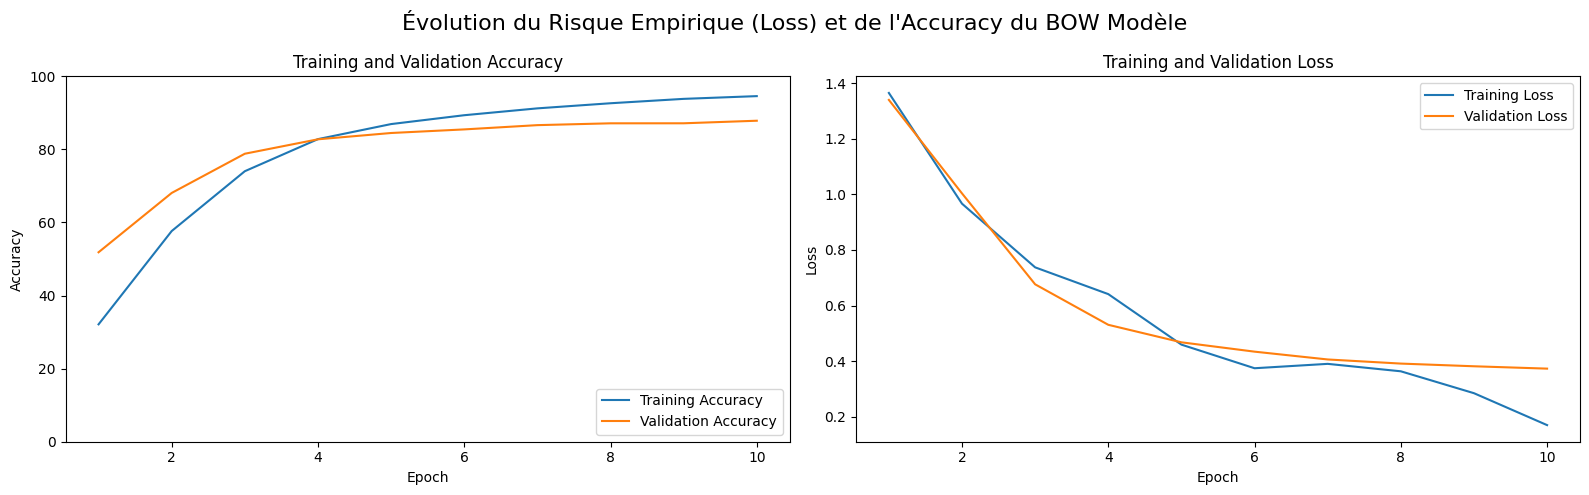

In [60]:
# Graphes Training and Validation (Accuracy and Loss)
trainer.plots(train_losses, valid_losses, train_accuracies, valid_accuracies, model_name="BOW Modèle")

In [61]:
# Initialisation
model = RNN(taille_vocab = TAILLE_VOCAB, taille_embed = DIM_EMBED, dim_cachee = DIM_CACHEE, num_outputs = NUM_OUTPUTS,)

# Cross-entropy Loss et optimisateur Adam
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trainer = train_valid_model(model=model, train_loader=train_loader, valid_loader=valid_loader, optimizer=optimizer, 
    criterion=criterion)

# Appeler la fonction d'entraînement et de validation
train_losses, valid_losses, train_accuracies, valid_accuracies = trainer.train_and_valid(epochs=10, model_name="RNN_Model")

Epoch 1/10 (RNN_Model): 100%|██████████| 120/120 [00:15<00:00,  7.76it/s]



Epoch: 1 	 Train Loss: 1.2316 	 Train Acc: 33.79% 	 Temps: 15.46s
Epoch: 1 	 Val Loss: 1.1968 	 Val Acc: 51.42%
Validation loss improved...



Epoch 2/10 (RNN_Model): 100%|██████████| 120/120 [00:15<00:00,  7.85it/s]



Epoch: 2 	 Train Loss: 0.7757 	 Train Acc: 61.83% 	 Temps: 15.28s
Epoch: 2 	 Val Loss: 0.8613 	 Val Acc: 67.51%
Validation loss improved...



Epoch 3/10 (RNN_Model): 100%|██████████| 120/120 [00:15<00:00,  7.70it/s]



Epoch: 3 	 Train Loss: 0.5385 	 Train Acc: 72.97% 	 Temps: 15.60s
Epoch: 3 	 Val Loss: 0.7412 	 Val Acc: 73.50%
Validation loss improved...



Epoch 4/10 (RNN_Model): 100%|██████████| 120/120 [00:15<00:00,  7.68it/s]



Epoch: 4 	 Train Loss: 0.6539 	 Train Acc: 79.93% 	 Temps: 15.63s
Epoch: 4 	 Val Loss: 0.6561 	 Val Acc: 76.72%
Validation loss improved...



Epoch 5/10 (RNN_Model): 100%|██████████| 120/120 [00:15<00:00,  7.76it/s]



Epoch: 5 	 Train Loss: 0.3047 	 Train Acc: 85.07% 	 Temps: 15.48s
Epoch: 5 	 Val Loss: 0.6236 	 Val Acc: 78.31%
Validation loss improved...



Epoch 6/10 (RNN_Model): 100%|██████████| 120/120 [00:15<00:00,  7.80it/s]



Epoch: 6 	 Train Loss: 0.8748 	 Train Acc: 86.27% 	 Temps: 15.39s
Epoch: 6 	 Val Loss: 1.1335 	 Val Acc: 65.57%
No improvement in validation loss for 1/2 epochs.



Epoch 7/10 (RNN_Model): 100%|██████████| 120/120 [00:15<00:00,  7.71it/s]



Epoch: 7 	 Train Loss: 0.4083 	 Train Acc: 85.09% 	 Temps: 15.58s
Epoch: 7 	 Val Loss: 0.5802 	 Val Acc: 80.33%
Validation loss improved...



Epoch 8/10 (RNN_Model): 100%|██████████| 120/120 [00:15<00:00,  7.94it/s]



Epoch: 8 	 Train Loss: 0.3848 	 Train Acc: 90.64% 	 Temps: 15.13s
Epoch: 8 	 Val Loss: 0.5987 	 Val Acc: 80.73%
No improvement in validation loss for 1/2 epochs.



Epoch 9/10 (RNN_Model): 100%|██████████| 120/120 [00:14<00:00,  8.02it/s]



Epoch: 9 	 Train Loss: 0.2120 	 Train Acc: 91.68% 	 Temps: 14.96s
Epoch: 9 	 Val Loss: 0.5622 	 Val Acc: 81.61%
Validation loss improved...



Epoch 10/10 (RNN_Model): 100%|██████████| 120/120 [00:15<00:00,  7.54it/s]



Epoch: 10 	 Train Loss: 0.3125 	 Train Acc: 93.21% 	 Temps: 15.93s
Epoch: 10 	 Val Loss: 0.6034 	 Val Acc: 81.19%
No improvement in validation loss for 1/2 epochs.



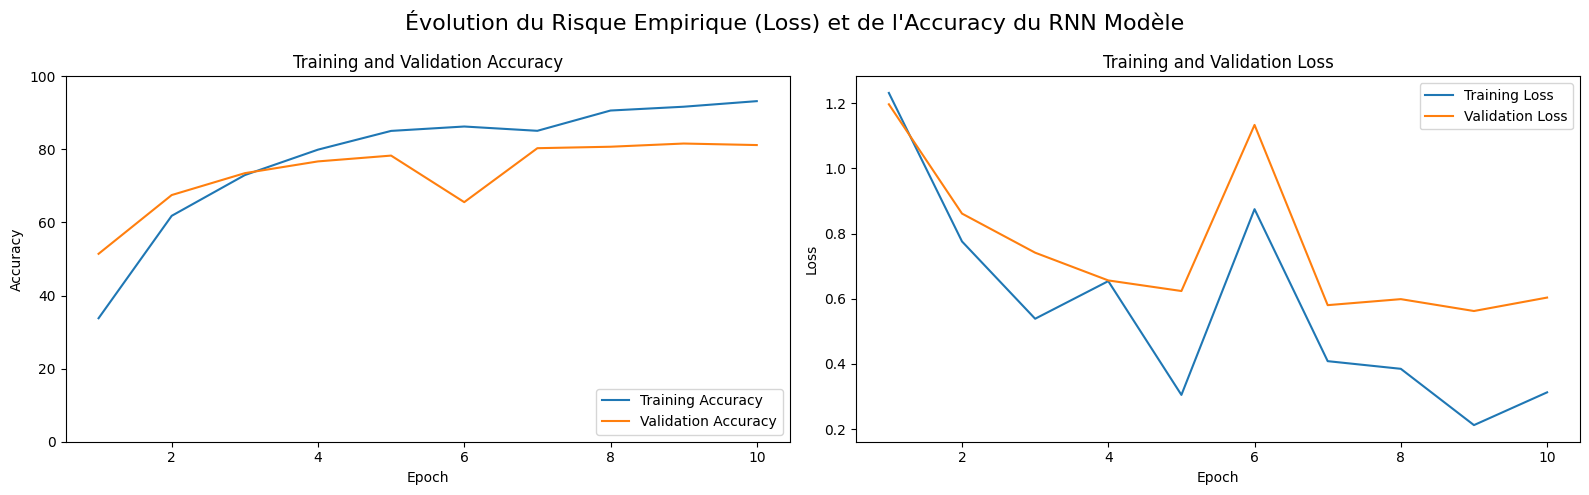

In [62]:
# Graphes Training and Validation (Accuracy and Loss)
trainer.plots(train_losses, valid_losses, train_accuracies, valid_accuracies, model_name="RNN Modèle")

In [63]:
# Initialisation
model = GRU(taille_vocab = TAILLE_VOCAB, taille_embed = DIM_EMBED, dim_cachee = DIM_CACHEE, num_outputs = NUM_OUTPUTS,)

# Cross-entropy Loss et optimisateur Adam
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trainer = train_valid_model(model=model, train_loader=train_loader, valid_loader=valid_loader, optimizer=optimizer, 
    criterion=criterion)

# Appeler la fonction d'entraînement et de validation
train_losses, valid_losses, train_accuracies, valid_accuracies = trainer.train_and_valid(epochs=10, model_name="GRU_Model")

Epoch 1/10 (GRU_Model): 100%|██████████| 120/120 [00:30<00:00,  3.97it/s]



Epoch: 1 	 Train Loss: 1.1188 	 Train Acc: 36.42% 	 Temps: 30.23s
Epoch: 1 	 Val Loss: 1.0402 	 Val Acc: 57.19%
Validation loss improved...



Epoch 2/10 (GRU_Model): 100%|██████████| 120/120 [00:27<00:00,  4.31it/s]



Epoch: 2 	 Train Loss: 0.5313 	 Train Acc: 70.78% 	 Temps: 27.82s
Epoch: 2 	 Val Loss: 0.6004 	 Val Acc: 78.03%
Validation loss improved...



Epoch 3/10 (GRU_Model): 100%|██████████| 120/120 [00:27<00:00,  4.41it/s]



Epoch: 3 	 Train Loss: 0.4651 	 Train Acc: 84.72% 	 Temps: 27.24s
Epoch: 3 	 Val Loss: 0.5041 	 Val Acc: 82.27%
Validation loss improved...



Epoch 4/10 (GRU_Model): 100%|██████████| 120/120 [00:27<00:00,  4.34it/s]



Epoch: 4 	 Train Loss: 0.3204 	 Train Acc: 90.44% 	 Temps: 27.65s
Epoch: 4 	 Val Loss: 0.4914 	 Val Acc: 83.28%
Validation loss improved...



Epoch 5/10 (GRU_Model): 100%|██████████| 120/120 [00:26<00:00,  4.55it/s]



Epoch: 5 	 Train Loss: 0.2106 	 Train Acc: 93.51% 	 Temps: 26.39s
Epoch: 5 	 Val Loss: 0.4950 	 Val Acc: 83.93%
No improvement in validation loss for 1/2 epochs.



Epoch 6/10 (GRU_Model): 100%|██████████| 120/120 [00:26<00:00,  4.48it/s]



Epoch: 6 	 Train Loss: 0.0676 	 Train Acc: 95.54% 	 Temps: 26.80s
Epoch: 6 	 Val Loss: 0.5558 	 Val Acc: 83.66%
No improvement in validation loss for 2/2 epochs.

Early stopping triggered.



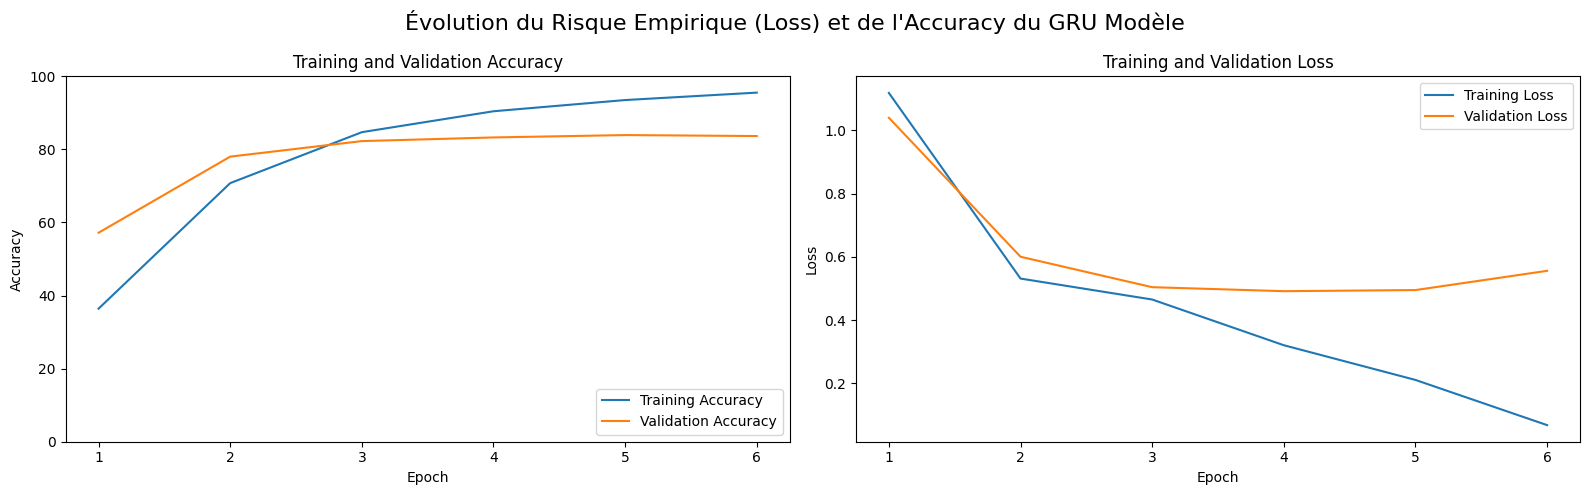

In [64]:
# Graphes Training and Validation (Accuracy and Loss)
trainer.plots(train_losses, valid_losses, train_accuracies, valid_accuracies, model_name="GRU Modèle")

In [65]:
# Initialisation
model = LSTM(taille_vocab = TAILLE_VOCAB, taille_embed = DIM_EMBED, dim_cachee = DIM_CACHEE, num_outputs = NUM_OUTPUTS,)

# Cross-entropy Loss et optimisateur Adam
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trainer = train_valid_model(model=model, train_loader=train_loader, valid_loader=valid_loader, optimizer=optimizer, 
    criterion=criterion)

# Appeler la fonction d'entraînement et de validation
train_losses, valid_losses, train_accuracies, valid_accuracies = trainer.train_and_valid(epochs=10, model_name="LSTM_Model")

Epoch 1/10 (LSTM_Model): 100%|██████████| 120/120 [00:18<00:00,  6.37it/s]



Epoch: 1 	 Train Loss: 1.0140 	 Train Acc: 37.67% 	 Temps: 18.83s
Epoch: 1 	 Val Loss: 1.1093 	 Val Acc: 47.99%
Validation loss improved...



Epoch 2/10 (LSTM_Model): 100%|██████████| 120/120 [00:18<00:00,  6.54it/s]



Epoch: 2 	 Train Loss: 0.8457 	 Train Acc: 62.57% 	 Temps: 18.37s
Epoch: 2 	 Val Loss: 0.8001 	 Val Acc: 67.24%
Validation loss improved...



Epoch 3/10 (LSTM_Model): 100%|██████████| 120/120 [00:18<00:00,  6.40it/s]



Epoch: 3 	 Train Loss: 0.5040 	 Train Acc: 75.43% 	 Temps: 18.77s
Epoch: 3 	 Val Loss: 0.6625 	 Val Acc: 74.36%
Validation loss improved...



Epoch 4/10 (LSTM_Model): 100%|██████████| 120/120 [00:18<00:00,  6.48it/s]



Epoch: 4 	 Train Loss: 0.4727 	 Train Acc: 83.35% 	 Temps: 18.53s
Epoch: 4 	 Val Loss: 0.6069 	 Val Acc: 78.09%
Validation loss improved...



Epoch 5/10 (LSTM_Model): 100%|██████████| 120/120 [00:18<00:00,  6.43it/s]



Epoch: 5 	 Train Loss: 0.4141 	 Train Acc: 87.32% 	 Temps: 18.66s
Epoch: 5 	 Val Loss: 0.5881 	 Val Acc: 79.64%
Validation loss improved...



Epoch 6/10 (LSTM_Model): 100%|██████████| 120/120 [00:18<00:00,  6.57it/s]



Epoch: 6 	 Train Loss: 0.3144 	 Train Acc: 90.63% 	 Temps: 18.28s
Epoch: 6 	 Val Loss: 0.5961 	 Val Acc: 80.64%
No improvement in validation loss for 1/2 epochs.



Epoch 7/10 (LSTM_Model): 100%|██████████| 120/120 [00:18<00:00,  6.61it/s]



Epoch: 7 	 Train Loss: 0.2228 	 Train Acc: 92.61% 	 Temps: 18.16s
Epoch: 7 	 Val Loss: 0.5971 	 Val Acc: 80.71%
No improvement in validation loss for 2/2 epochs.

Early stopping triggered.



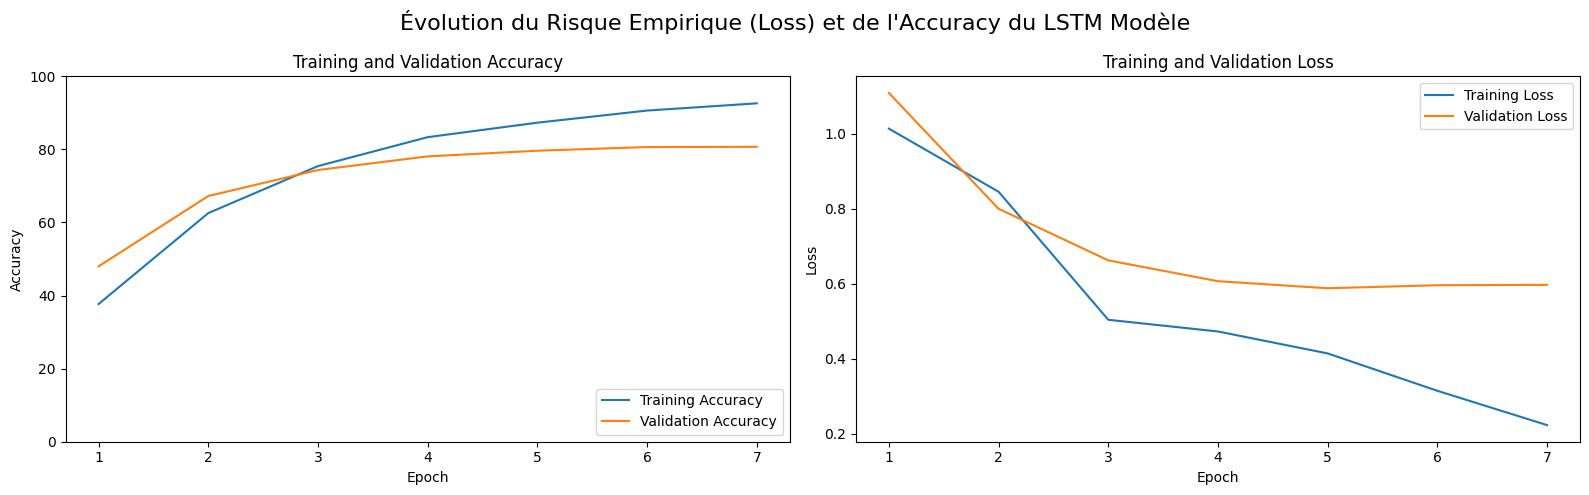

In [66]:
# Graphes Training and Validation (Accuracy and Loss)
trainer.plots(train_losses, valid_losses, train_accuracies, valid_accuracies, model_name="LSTM Modèle")